In [3]:
import pandas as pd
import numpy as np
import os
import logging
from pathlib import Path
import gc
import warnings
warnings.filterwarnings('ignore')

# Image Processing
import cv2
from PIL import Image, ImageEnhance

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2  # Back to MobileNetV2 like your original
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, 
    Input, Conv2D, Multiply, Lambda, Add
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional, Dict, Any

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [4]:
def configure_gpu():
    """Configure GPU settings for optimal performance"""
    try:
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logger.info(f"Configured {len(gpus)} GPU(s) with memory growth")
        else:
            logger.info("No GPU found, using CPU")
    except RuntimeError as e:
        logger.error(f"GPU configuration failed: {e}")


In [5]:
def clear_session():
    """Clear TensorFlow session and free memory"""
    tf.keras.backend.clear_session()
    gc.collect()
    logger.info("Cleared TensorFlow session and freed memory")

class ConservativeDataGenerator(Sequence):
    """Conservative data generator similar to your original but with improvements"""
    
    def __init__(self, dataframe: pd.DataFrame, image_dir: str, img_size: Tuple[int, int], 
                 batch_size: int = 16, augment: bool = False, shuffle: bool = True):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        # Initialize batch arrays
        X = np.zeros((len(batch_indices), *self.img_size, 3), dtype=np.float32)
        y = np.zeros(len(batch_indices), dtype=np.int32)
        
        valid_samples = 0
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.image_dir, row['path'])
            img = self._preprocess_image(img_path)
            
            if img is not None:
                X[valid_samples] = img
                y[valid_samples] = row['label_encoded']
                valid_samples += 1
        
        # Return only valid samples - but ensure we have the right batch size
        if valid_samples < len(batch_indices):
            X = X[:valid_samples]
            y = y[:valid_samples]
        
        return X, y
    
    def _preprocess_image(self, image_path: str) -> Optional[np.ndarray]:
        """Load and preprocess image - keeping it simple like your original"""
        try:
            if not os.path.exists(image_path):
                return None
            
            # Load image
            img = cv2.imread(image_path)
            if img is None:
                return None
            
            # Convert color space
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize image
            img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)
            
            # Simple normalization like your original
            img = img.astype(np.float32) / 255.0
            
            # Very light augmentation only for training
            if self.augment and np.random.random() > 0.7:
                # Only horizontal flip - most conservative augmentation
                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            
            return img
            
        except Exception as e:
            logger.error(f"Error processing image {image_path}: {e}")
            return None
    
    def on_epoch_end(self):
        """Shuffle indices after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)


In [6]:
class OralCancerDataset:
    """Dataset class similar to your original but with improvements"""
    
    def __init__(self, image_dir: str, labels_file: str, img_size: Tuple[int, int] = (224, 224)):
        self.image_dir = image_dir
        self.img_size = img_size
        self.df = self._load_and_validate_data(labels_file)
        self.label_encoder = LabelEncoder()
        self._prepare_labels()
        
    def _load_and_validate_data(self, labels_file: str) -> pd.DataFrame:
        """Load and validate dataset"""
        try:
            df = pd.read_csv(labels_file)
            logger.info(f"Loaded dataset with {len(df)} samples")
            
            # Basic validation
            required_columns = ['path', 'label_number']
            for col in required_columns:
                if col not in df.columns:
                    raise ValueError(f"Missing required column: {col}")
            
            # Remove samples with missing paths
            df = df.dropna(subset=['path'])
            logger.info(f"Dataset after removing missing paths: {len(df)} samples")
            
            return df
            
        except Exception as e:
            logger.error(f"Error loading dataset: {e}")
            raise
    
    def _prepare_labels(self):
        """Prepare and encode labels - exactly like your original"""
        self.df['label_number'] = self.df['label_number'].astype(str)
        self.df['label_encoded'] = self.label_encoder.fit_transform(self.df['label_number'])
        self.class_names = [str(cls) for cls in self.label_encoder.classes_]
        self.num_classes = len(self.class_names)
        
        # Log class distribution
        class_counts = self.df['label_encoded'].value_counts().sort_index()
        logger.info(f"Class distribution: {dict(class_counts)}")
    
    def create_data_generators(self, batch_size: int = 16, validation_split: float = 0.25, 
                             test_split: float = 0.2) -> Tuple[ConservativeDataGenerator, ...]:
        """Create train, validation, and test generators - same splits as your original"""
        
        # First split: separate test set (same as your original)
        train_val_idx, test_idx = train_test_split(
            np.arange(len(self.df)),
            test_size=test_split,
            random_state=42,
            stratify=self.df['label_encoded']
        )
        
        # Second split: separate train and validation (same as your original)
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=validation_split,
            random_state=42,
            stratify=self.df.iloc[train_val_idx]['label_encoded']
        )
        
        # Create generators with light augmentation
        train_generator = ConservativeDataGenerator(
            self.df.iloc[train_idx], self.image_dir, self.img_size,
            batch_size=batch_size, augment=True, shuffle=True
        )
        
        val_generator = ConservativeDataGenerator(
            self.df.iloc[val_idx], self.image_dir, self.img_size,
            batch_size=batch_size, augment=False, shuffle=False
        )
        
        test_generator = ConservativeDataGenerator(
            self.df.iloc[test_idx], self.image_dir, self.img_size,
            batch_size=batch_size, augment=False, shuffle=False
        )
        
        logger.info(f"Created generators - Train: {len(train_generator)}, "
                   f"Val: {len(val_generator)}, Test: {len(test_generator)} batches")
        
        return train_generator, val_generator, test_generator


In [7]:
class ImprovedOralCancerModel:
    """Improved model that maintains your original architecture but with enhancements"""
    
    def __init__(self, num_classes: int, img_size: Tuple[int, int] = (224, 224)):
        self.num_classes = num_classes
        self.img_size = img_size
        self.model = self._build_model()
        self.history = None
        
    def _build_model(self) -> Model:
        """Build model similar to your original but with small improvements"""
        
        # Input layer
        input_tensor = Input(shape=(*self.img_size, 3))
        
        # Base model - MobileNetV2 like your original
        base_model = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_tensor=input_tensor
        )
        
        # Keep frozen initially like your original
        base_model.trainable = False
        
        # Add custom layers - similar to your original but slightly improved
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)  # Same dropout as your original
        x = Dense(128, activation='relu')(x)  # Same size as your original
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)  # Same dropout as your original
        
        # Output layer
        predictions = Dense(self.num_classes, activation='softmax')(x)
        
        model = Model(inputs=input_tensor, outputs=predictions)
        
        return model
    
    def compile_model(self, learning_rate: float = 1e-4):
        """Compile model with settings similar to your original"""
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),  # Same optimizer as your original
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        logger.info(f"Model compiled with learning rate: {learning_rate}")
        logger.info(f"Model parameters: {self.model.count_params():,}")
    
    def get_callbacks(self, patience: int = 5) -> List[callbacks.Callback]:
        """Get training callbacks - similar to your original"""
        return [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=patience,  # Same patience as your original
                restore_best_weights=True,
                verbose=1
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,  # Same factor as your original
                patience=3,  # Same patience as your original
                min_lr=1e-6,  # Same min_lr as your original
                verbose=1
            ),
            callbacks.ModelCheckpoint(
                'best_oral_cancer_model.h5',
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]
    
    def train_model(self, train_gen, val_gen, epochs: int = 50):
        """Simple training like your original but with improvements"""
        
        logger.info("Training model with frozen base layers")
        self.compile_model(learning_rate=1e-4)  # Same learning rate as your original
        
        # Train with frozen base model first
        history = self.model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=epochs,
            callbacks=self.get_callbacks(patience=5),
            verbose=1
        )
        
        self.history = history
        return history
    
    def evaluate_model(self, test_gen, class_names: List[str]) -> Dict[str, Any]:
        """Evaluate model similar to your original"""
        
        # Collect all predictions and true labels
        y_true = []
        y_pred = []
        
        for i in range(len(test_gen)):
            X_batch, y_batch = test_gen[i]
            
            if X_batch.shape[0] == 0:
                continue
                
            pred_proba = self.model.predict(X_batch, verbose=0)
            pred_classes = np.argmax(pred_proba, axis=1)
            
            y_true.extend(y_batch)
            y_pred.extend(pred_classes)
        
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        # Calculate metrics
        accuracy = np.mean(y_true == y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        # Classification report
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'classification_report': report,
            'confusion_matrix': cm,
            'y_true': y_true,
            'y_pred': y_pred
        }
        
        logger.info(f"Evaluation Results - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        return results


In [8]:
class Visualizer:
    """Visualization class like your original"""
    
    @staticmethod
    def plot_training_history(history, save_path: Optional[str] = None):
        """Plot training history like your original"""
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Accuracy
        ax1.plot(history.history['accuracy'], label='Training')
        ax1.plot(history.history['val_accuracy'], label='Validation')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Loss
        ax2.plot(history.history['loss'], label='Training')
        ax2.plot(history.history['val_loss'], label='Validation')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, classes, save_path: Optional[str] = None):
        """Plot confusion matrix like your original"""
        
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes,
                    yticklabels=classes)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()


In [9]:
def evaluate_model_comprehensive(model, test_generator, class_names, visualizer):
    """Evaluation function like your original but improved"""
    
    y_true = []
    y_pred = []

    for i in range(len(test_generator)):
        X_batch, y_batch = test_generator[i]

        if X_batch.shape[0] == 0:
            continue
        
        preds = model.model.predict(X_batch, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(y_batch)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if len(y_true) == 0 or len(y_pred) == 0:
        print("Error: No valid predictions were made.")
        return

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    visualizer.plot_confusion_matrix(y_true, y_pred, class_names)

    accuracy = np.mean(y_true == y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy


In [10]:
def main():
    """Main function similar to your original but with improvements"""
    
    # Configure GPU
    configure_gpu()
    
    try:
        # Your original paths
        IMAGE_DIR = r"E:\NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data\NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data\patch\images"
        LABELS_FILE = r"E:\NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data\NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data\patch\sabpatch_parsed_folders.csv"
        
        # Create dataset
        dataset = OralCancerDataset(IMAGE_DIR, LABELS_FILE)
        
        # Create data generators with same batch size as your original
        train_gen, val_gen, test_gen = dataset.create_data_generators(batch_size=16)
        
        # Create and train model
        model = ImprovedOralCancerModel(num_classes=dataset.num_classes)
        
        # Train model (similar to your original approach)
        history = model.train_model(train_gen, val_gen, epochs=50)
        
        # Evaluate model
        results = model.evaluate_model(test_gen, dataset.class_names)
        
        # Visualization
        visualizer = Visualizer()
        visualizer.plot_training_history(history)
        
        # Comprehensive evaluation like your original
        evaluate_model_comprehensive(model, test_gen, dataset.class_names, visualizer)
        
        # Print results
        print(f"Final Test Accuracy: {results['accuracy']:.4f}")
        print(f"Final Test F1-Score: {results['f1_score']:.4f}")
        
        # Save model
        model.model.save('improved_oral_cancer_model.h5')
        logger.info("Model saved successfully")
        
    except Exception as e:
        logger.error(f"Error in main execution: {e}")
        raise
    finally:
        # Clean up
        clear_session()

INFO:__main__:No GPU found, using CPU
INFO:__main__:Loaded dataset with 3763 samples
INFO:__main__:Dataset after removing missing paths: 3763 samples
INFO:__main__:Class distribution: {0: np.int64(707), 1: np.int64(1126), 2: np.int64(1930)}
INFO:__main__:Created generators - Train: 142, Val: 48, Test: 48 batches
INFO:__main__:Training model with frozen base layers
INFO:__main__:Model compiled with learning rate: 0.0001
INFO:__main__:Model parameters: 2,422,851


Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.4019 - loss: 1.4448
Epoch 1: val_loss improved from inf to 0.97902, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 89s 572ms/step - accuracy: 0.4021 - loss: 1.4446 - val_accuracy: 0.5299 - val_loss: 0.9790 - learning_rate: 1.0000e-04
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.4732 - loss: 1.2721
Epoch 2: val_loss improved from 0.97902 to 0.93307, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 75s 526ms/step - accuracy: 0.4733 - loss: 1.2719 - val_accuracy: 0.5525 - val_loss: 0.9331 - learning_rate: 1.0000e-04
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5061 - loss: 1.1800
Epoch 3: val_loss improved from 0.93307 to 0.90524, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 70s 490ms/step - accuracy: 0.5062 - loss: 1.1798 - val_accuracy: 0.5790 - val_loss: 0.9052 - learning_rate: 1.0000e-04
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.5369 - loss: 1.0768
Epoch 4: val_loss improved from 0.90524 to 0.87754, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 69s 487ms/step - accuracy: 0.5370 - loss: 1.0766 - val_accuracy: 0.6109 - val_loss: 0.8775 - learning_rate: 1.0000e-04
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5863 - loss: 0.9894
Epoch 5: val_loss improved from 0.87754 to 0.86828, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 68s 481ms/step - accuracy: 0.5863 - loss: 0.9894 - val_accuracy: 0.5910 - val_loss: 0.8683 - learning_rate: 1.0000e-04
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.5996 - loss: 0.9351
Epoch 6: val_loss improved from 0.86828 to 0.80656, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 71s 497ms/step - accuracy: 0.5996 - loss: 0.9351 - val_accuracy: 0.6388 - val_loss: 0.8066 - learning_rate: 1.0000e-04
Epoch 7/50
141/142 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.5989 - loss: 0.9145
Epoch 7: val_loss improved from 0.80656 to 0.75336, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 70s 492ms/step - accuracy: 0.5989 - loss: 0.9146 - val_accuracy: 0.6746 - val_loss: 0.7534 - learning_rate: 1.0000e-04
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6306 - loss: 0.8742
Epoch 8: val_loss improved from 0.75336 to 0.75219, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.6306 - loss: 0.8743 - val_accuracy: 0.6574 - val_loss: 0.7522 - learning_rate: 1.0000e-04
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6089 - loss: 0.8911
Epoch 9: val_loss improved from 0.75219 to 0.72263, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 68s 482ms/step - accuracy: 0.6090 - loss: 0.8910 - val_accuracy: 0.6799 - val_loss: 0.7226 - learning_rate: 1.0000e-04
Epoch 10/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.6259 - loss: 0.8240
Epoch 10: val_loss improved from 0.72263 to 0.71233, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 71s 498ms/step - accuracy: 0.6259 - loss: 0.8243 - val_accuracy: 0.6972 - val_loss: 0.7123 - learning_rate: 1.0000e-04
Epoch 11/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6471 - loss: 0.8306
Epoch 11: val_loss improved from 0.71233 to 0.68040, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 70s 492ms/step - accuracy: 0.6472 - loss: 0.8304 - val_accuracy: 0.7171 - val_loss: 0.6804 - learning_rate: 1.0000e-04
Epoch 12/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6434 - loss: 0.7920
Epoch 12: val_loss improved from 0.68040 to 0.67050, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 67s 472ms/step - accuracy: 0.6434 - loss: 0.7921 - val_accuracy: 0.7185 - val_loss: 0.6705 - learning_rate: 1.0000e-04
Epoch 13/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.6613 - loss: 0.8027
Epoch 13: val_loss improved from 0.67050 to 0.66550, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 70s 492ms/step - accuracy: 0.6612 - loss: 0.8029 - val_accuracy: 0.7264 - val_loss: 0.6655 - learning_rate: 1.0000e-04
Epoch 14/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.6537 - loss: 0.8135
Epoch 14: val_loss improved from 0.66550 to 0.66498, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 70s 495ms/step - accuracy: 0.6537 - loss: 0.8134 - val_accuracy: 0.7185 - val_loss: 0.6650 - learning_rate: 1.0000e-04
Epoch 15/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6799 - loss: 0.7268
Epoch 15: val_loss did not improve from 0.66498
142/142 ━━━━━━━━━━━━━━━━━━━━ 68s 476ms/step - accuracy: 0.6798 - loss: 0.7270 - val_accuracy: 0.7158 - val_loss: 0.6698 - learning_rate: 1.0000e-04
Epoch 16/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6665 - loss: 0.7792
Epoch 16: val_loss improved from 0.66498 to 0.65704, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 68s 475ms/step - accuracy: 0.6665 - loss: 0.7791 - val_accuracy: 0.7211 - val_loss: 0.6570 - learning_rate: 1.0000e-04
Epoch 17/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6568 - loss: 0.7876
Epoch 17: val_loss improved from 0.65704 to 0.64054, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 66s 465ms/step - accuracy: 0.6569 - loss: 0.7874 - val_accuracy: 0.7304 - val_loss: 0.6405 - learning_rate: 1.0000e-04
Epoch 18/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7100 - loss: 0.6725
Epoch 18: val_loss improved from 0.64054 to 0.63731, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 67s 472ms/step - accuracy: 0.7100 - loss: 0.6727 - val_accuracy: 0.7304 - val_loss: 0.6373 - learning_rate: 1.0000e-04
Epoch 19/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.6907 - loss: 0.7368
Epoch 19: val_loss improved from 0.63731 to 0.62500, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 67s 472ms/step - accuracy: 0.6906 - loss: 0.7369 - val_accuracy: 0.7344 - val_loss: 0.6250 - learning_rate: 1.0000e-04
Epoch 20/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.6993 - loss: 0.7377
Epoch 20: val_loss improved from 0.62500 to 0.62028, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 68s 480ms/step - accuracy: 0.6993 - loss: 0.7376 - val_accuracy: 0.7371 - val_loss: 0.6203 - learning_rate: 1.0000e-04
Epoch 21/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7069 - loss: 0.7057
Epoch 21: val_loss did not improve from 0.62028
142/142 ━━━━━━━━━━━━━━━━━━━━ 68s 481ms/step - accuracy: 0.7068 - loss: 0.7058 - val_accuracy: 0.7357 - val_loss: 0.6280 - learning_rate: 1.0000e-04
Epoch 22/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7077 - loss: 0.6740
Epoch 22: val_loss did not improve from 0.62028
142/142 ━━━━━━━━━━━━━━━━━━━━ 69s 487ms/step - accuracy: 0.7077 - loss: 0.6742 - val_accuracy: 0.7344 - val_loss: 0.6250 - learning_rate: 1.0000e-04
Epoch 23/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6902 - loss: 0.7233
Epoch 23: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 23: val_loss did not improve from 0.62028
142/142 ━━━━━━━━━━━━━━━━━━━━ 67s 471ms/step - accuracy: 0.6902 - l

142/142 ━━━━━━━━━━━━━━━━━━━━ 65s 456ms/step - accuracy: 0.6783 - loss: 0.7010 - val_accuracy: 0.7384 - val_loss: 0.6197 - learning_rate: 2.0000e-05
Epoch 25/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6758 - loss: 0.7213
Epoch 25: val_loss improved from 0.61969 to 0.61715, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 63s 440ms/step - accuracy: 0.6758 - loss: 0.7212 - val_accuracy: 0.7357 - val_loss: 0.6172 - learning_rate: 2.0000e-05
Epoch 26/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6886 - loss: 0.7022
Epoch 26: val_loss improved from 0.61715 to 0.61626, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 68s 481ms/step - accuracy: 0.6886 - loss: 0.7023 - val_accuracy: 0.7371 - val_loss: 0.6163 - learning_rate: 2.0000e-05
Epoch 27/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.7104 - loss: 0.6751
Epoch 27: val_loss improved from 0.61626 to 0.61375, saving model to best_oral_cancer_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 68s 481ms/step - accuracy: 0.7103 - loss: 0.6752 - val_accuracy: 0.7397 - val_loss: 0.6137 - learning_rate: 2.0000e-05
Epoch 28/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7145 - loss: 0.6933
Epoch 28: val_loss did not improve from 0.61375
142/142 ━━━━━━━━━━━━━━━━━━━━ 67s 473ms/step - accuracy: 0.7146 - loss: 0.6933 - val_accuracy: 0.7410 - val_loss: 0.6152 - learning_rate: 2.0000e-05
Epoch 29/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6945 - loss: 0.6958
Epoch 29: val_loss did not improve from 0.61375
142/142 ━━━━━━━━━━━━━━━━━━━━ 66s 467ms/step - accuracy: 0.6946 - loss: 0.6957 - val_accuracy: 0.7384 - val_loss: 0.6160 - learning_rate: 2.0000e-05
Epoch 30/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.7110 - loss: 0.6882
Epoch 30: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 30: val_loss did not improve from 0.61375
142/142 ━━━━━━━━━━━━━━━━━━━━ 63s 445ms/step - accuracy: 0.7109 - lo

INFO:__main__:Evaluation Results - Accuracy: 0.7331, F1: 0.7334


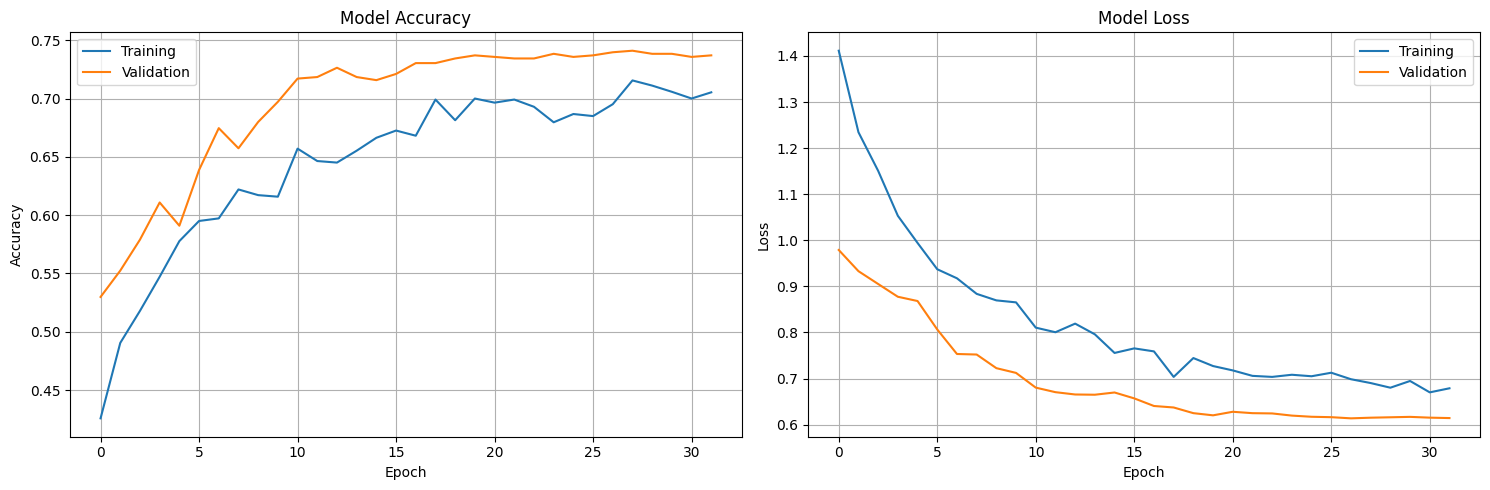

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.67      0.66       142
           1       0.76      0.77      0.76       225
           2       0.76      0.74      0.75       386

    accuracy                           0.73       753
   macro avg       0.72      0.72      0.72       753
weighted avg       0.73      0.73      0.73       753



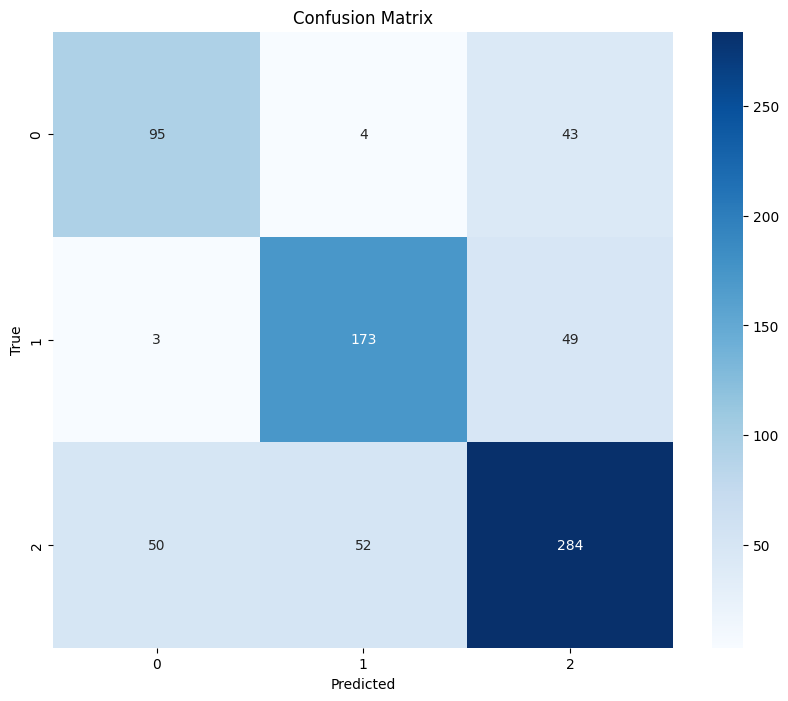

Test Accuracy: 0.7331
Final Test Accuracy: 0.7331
Final Test F1-Score: 0.7334


INFO:__main__:Model saved successfully
INFO:__main__:Cleared TensorFlow session and freed memory


In [12]:
if __name__ == "__main__":
    main()